In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

FS = (8, 4)  # figure size
RS = 124  # random seed

In [2]:
X, y = load_breast_cancer(return_X_y=True)
n_feat = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RS
)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

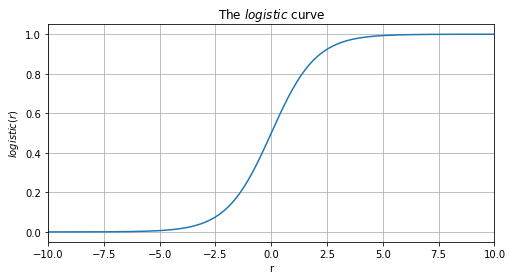

In [3]:
def logistic(r):
    return 1 / (1 + jnp.exp(-r))


b = 10
r = jnp.linspace(-b, b, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(r, logistic(r))
ax.grid()
_ = ax.set(xlabel="r", ylabel="$logistic(r)$", title="The $logistic$ curve")
_ = ax.set_xlim(-b, b)

In [4]:
def predict(c, w, X):
    return logistic(jnp.dot(X, w) + c)

In [5]:
def cost(c, w, X, y, eps=1e-14, lmbd=0.1):
    n = y.size
    p = predict(c, w, X)
    p = jnp.clip(p, eps, 1 - eps)  # bound the probabilities within (0,1) to avoid ln(0)
    return -jnp.sum(y * jnp.log(p) + (1 - y) * jnp.log(1 - p)) / n + 0.5 * lmbd * (
        jnp.dot(w, w) + c * c
    )

In [6]:
c_0 = 1.0
w_0 = 1.0e-5 * jnp.ones(n_feat)
print(cost(c_0, w_0, X_train_s, y_train))

0.7365704


In [11]:
X_train_s.shape[0]

426

# Batch Gradient Descent

In [19]:
%%time
n_iter = 1000
eta = 5e-2
tol = 1e-6
w = w_0
c = c_0
new_cost = float(cost(c, w, X_train_s, y_train))
cost_hist = [new_cost]
for i in range(n_iter):
    c_current = c
    c -= eta * grad(cost, argnums=0)(c_current, w, X_train_s, y_train)
    w -= eta * grad(cost, argnums=1)(c_current, w, X_train_s, y_train)
    new_cost = float(cost(c, w, X_train_s, y_train))
    cost_hist.append(new_cost)
    if (i > 20) and (i % 10 == 0):
        if jnp.abs(cost_hist[-1] - cost_hist[-20]) < tol:
            print(f"Exited loop at iteration {i}")
            break

Exited loop at iteration 680
CPU times: user 29.1 s, sys: 227 ms, total: 29.4 s
Wall time: 32.2 s


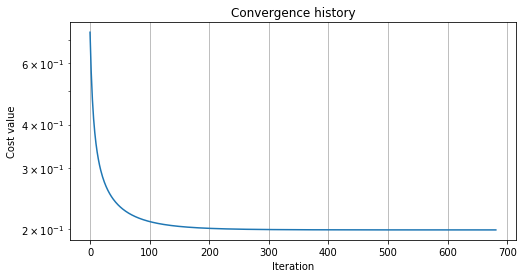

In [20]:
_, ax = plt.subplots(figsize=FS)
plt.semilogy(cost_hist)
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

# Stochastic Gradient Descent

In [14]:
%%time
n_iter = X_train_s.shape[0]#1000
eta = 5e-2
tol = 1e-6
w = w_0
c = c_0
new_cost = float(cost(c, w, X_train_s[0], y_train[0]))
cost_hist = [new_cost]
for i in range(n_iter):
    c_current = c
    c -= eta * grad(cost, argnums=0)(c_current, w, X_train_s[i], y_train[i])
    w -= eta * grad(cost, argnums=1)(c_current, w, X_train_s[i], y_train[i])
    new_cost = float(cost(c, w, X_train_s, y_train))
    cost_hist.append(new_cost)
    if (i > 20) and (i % 10 == 0):
        if jnp.abs(cost_hist[-1] - cost_hist[-20]) < tol:
            print(f"Exited loop at iteration {i}")
            break

CPU times: user 19.2 s, sys: 81.1 ms, total: 19.3 s
Wall time: 20.8 s


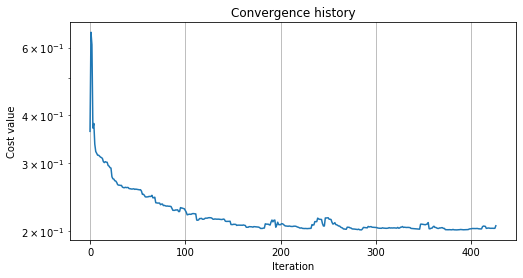

In [15]:
_, ax = plt.subplots(figsize=FS)
plt.semilogy(cost_hist)
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

In [9]:
y_pred_proba = predict(c, w, X_test_s)
y_pred = jnp.array(y_pred_proba)
y_pred = jnp.where(y_pred < 0.5, y_pred, 1.0)
y_pred = jnp.where(y_pred >= 0.5, y_pred, 0.0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        53
           1       0.98      0.97      0.97        90

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143

